# Heatmap - Extra functionalities

In [1]:
from datetime import date
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


import predictivehp.processing.data_processing as dp
import predictivehp.models.models as models
import predictivehp.visualization.plotter as pltr

%config InlineBackend.figure_format = 'retina'
mpl.rcdefaults()
rc = {
    'figure.facecolor': 'black',
    'figure.figsize': (6.75, 4),  # Values for Jup. Lab // (6.0, 4.0) default

    'xtick.color': 'white',
    'xtick.major.size': 3,
    'xtick.top': False,
    'xtick.bottom': True,

    'ytick.color': 'white',
    'ytick.major.size': 3,
    'ytick.left': True,
    'ytick.right': False,

    'axes.facecolor': '#100000',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'white',
    'axes.grid': True,
    'axes.axisbelow': True,

    'text.color': 'white',

    'legend.shadow': True,
    'legend.framealpha': 1.0,

    'grid.color': '#250000',
}
mpl.rcParams.update(rc)
f_size = mpl.rcParams.get('figure.figsize')

In [2]:
b_path = 'predictivehp/data'
s_shp_p = f'{b_path}/streets.shp'
c_shp_p = f'{b_path}/councils.shp'
cl_shp_p = f'{b_path}/citylimit.shp'

pp = dp.PreProcessing(data=0)  # Para que no llame automatico al pp.get_data()
shps = pp.shps_processing(s_shp_p, c_shp_p, cl_shp_p)
# data_0 = pp.get_data()
data_0 = None

In [3]:
rfr = models.RForestRegressor(data_0=data_0, shps=shps,
                              read_data=True, w_data=False,
                              read_X=True, w_X=False)
# pp.models = [rfr]
# pp.define_models()
# X_train, y_train = pp.prepare_rfr('train', 'default')
# X_test, y_test = pp.prepare_rfr('test', 'default')

# rfr.fit(X_train, y_train)
# rfr.predict(X_test)

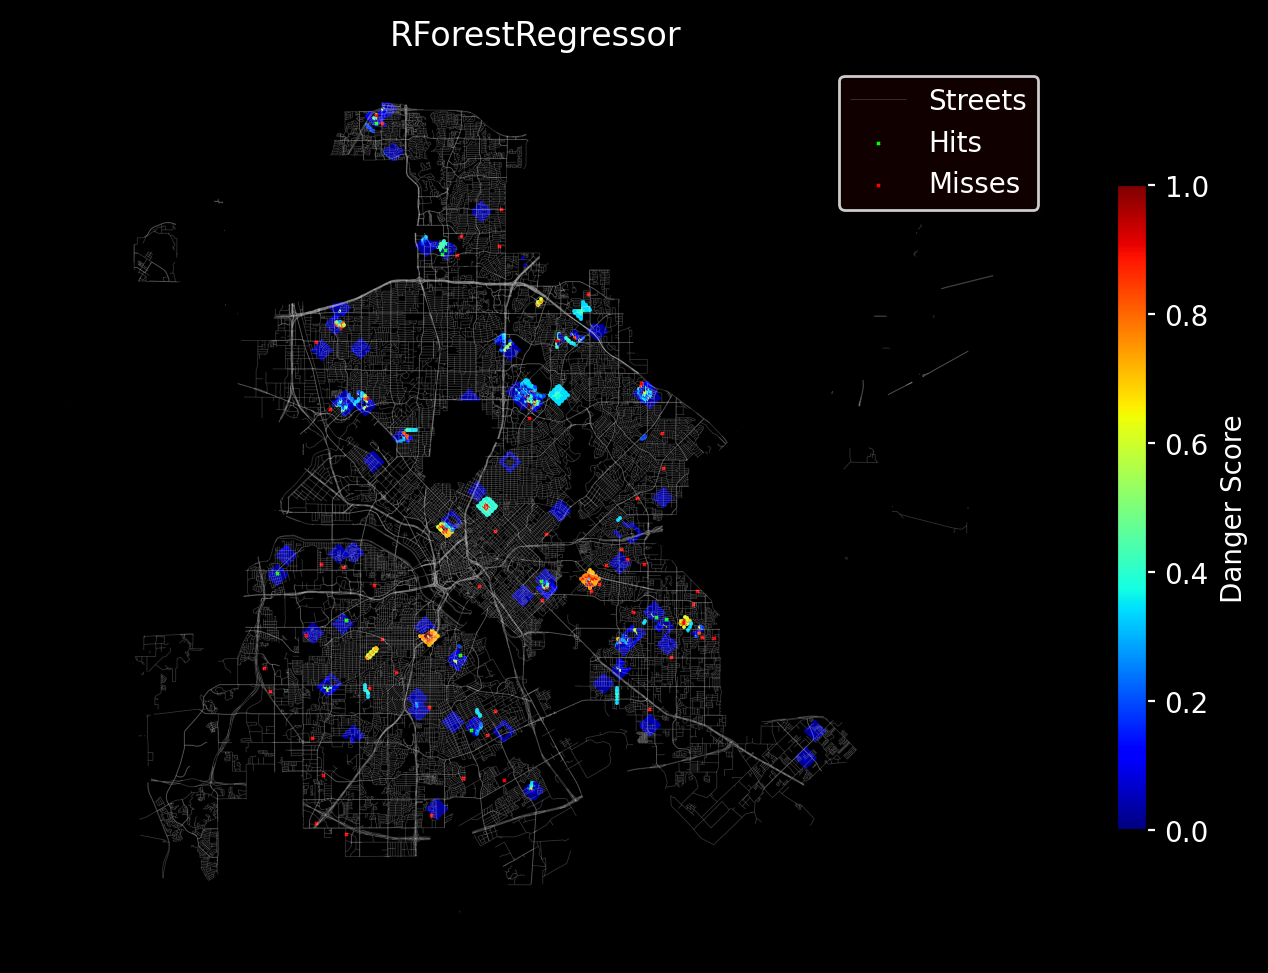

In [57]:
def heatmap(c=0, show_score=False, incidences=False,
            savefig=False, fname='', **kwargs):
    cells = rfr.X[[('geometry', ''), ('Dangerous_pred', '')]]
    cells = gpd.GeoDataFrame(cells)
    d_cells = cells[cells[('Dangerous_pred', '')] >= c]  #  Dangerous cells
    d_streets = rfr.shps['streets']

    fig, ax = plt.subplots(figsize=[f_size[0]] * 2)
    fig.dpi = 300
    d_streets.plot(ax=ax, alpha=0.2, lw=0.3, color="w", label="Streets")
    if show_score:
        d_cells.plot(ax=ax, column=('Dangerous_pred', ''), cmap='jet',
                     marker=',', markersize=0.1)
    else:
        d_cells.plot(ax=ax, marker=',', markersize=0.1, color='darkblue',
                     label='Hotspot')

    if incidences:
        if type(c) == list or type(c) == tuple:
            cells['Hit'] = np.where(
                (c[0] <= cells[('Dangerous_pred', '')])
                & (cells[('Dangerous_pred', '')] <= c[1]),
                1, 0)

        else:
            cells['Hit'] = np.where(
                cells[('Dangerous_pred', '')] >= c, 1, 0
            )

        data_nov = pd.DataFrame(rfr.data[
            (date(2017, 11, 1) <= rfr.data.date) &
            (rfr.data.date <= date(2017, 11, 7))
        ])
        data_nov.columns = pd.MultiIndex.from_product([data_nov.columns, ['']])
        cells.drop(columns='geometry', inplace=True)
        join_ = data_nov.join(cells)

        hits = gpd.GeoDataFrame(join_[join_['Hit'] == 1])
        misses = gpd.GeoDataFrame(join_[join_['Hit'] == 0])
        if not hits.empty:
            hits.plot(ax=ax, marker='x', markersize=0.25, color='lime',
                      label="Hits")
        if not misses.empthy:
            misses.plot(ax=ax, marker='x', markersize=0.25, color='r',
                        label="Misses")

    ax.set_axis_off()
    plt.title('RForestRegressor')
    plt.legend()

    if show_score:
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        cmap = mpl.cm.jet
        mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        divider = make_axes_locatable(ax)
        c_bar = fig.colorbar(mappable, ax=ax,
                             fraction=0.15,
                             shrink=0.5,
                             aspect=21.5)
        c_bar.ax.set_ylabel('Danger Score')

    plt.tight_layout()
    if savefig:
        plt.savefig(fname, **kwargs)
    plt.show()


heatmap(c=0.1, incidences=True, show_score=True,
        savefig=False, fname='hm_example.png')

In [6]:
d_incidents = 0
h_area = 0.0


def validate(c=0):
    global d_incidents, h_area
    cells = rfr.X[[('geometry', ''), ('Dangerous_pred', '')]]
    cells = gpd.GeoDataFrame(cells)
    d_cells = cells[cells[('Dangerous_pred', '')] >= c]

    if type(c) == list or type(c) == tuple:
        cells['Hit'] = np.where(
            (c[0] <= cells[('Dangerous_pred', '')])
            & (cells[('Dangerous_pred', '')] <= c[1]),
            1, 0)

    else:
        cells['Hit'] = np.where(
            cells[('Dangerous_pred', '')] >= c, 1, 0
        )

    data_nov = pd.DataFrame(rfr.data[
        (date(2017, 11, 1) <= rfr.data.date) &
        (rfr.data.date <= date(2017, 11, 7))
    ])
    data_nov.columns = pd.MultiIndex.from_product([data_nov.columns, ['']])
    cells.drop(columns='geometry', inplace=True)
    join_ = data_nov.join(cells)

    hits = gpd.GeoDataFrame(join_[join_['Hit'] == 1])
#     misses = gpd.GeoDataFrame(join_[join_['Hit'] == 0])

    d_incidents = hits.shape[0]
    h_area = d_cells.shape[0]  # *(100**2) pero el print dejarlo en m2


c = 0
validate(c)

print(f"{'Detected Incidents:':<20} {d_incidents:<3d}")
print(f"{'Hotspot Area:':<20} {h_area:<5.2f} ha")

Detected Incidents:  61 
Hotspot Area:        140335.00 ha
